In [40]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from syd import make_viewer, Viewer

from src.files import results_dir
from src.plotting import errorPlot
from src.iaf.source_population import SourcePopulationGabor
from src.iaf.analysis import (
    gather_metadata,
    gather_results,
    gather_rates,
    gather_weights,
    gather_num_connections,
    get_groupnames,
    sort_orientation_preference,
    summarize_weights,
    get_norm_factor,
)
from src.iaf.plotting import weights_to_gabor

In [42]:
config = "hofer_replacement"
run_name = "20250426"

if config == "hofer_replacement":
    norm_by_max_weight = True
    norm_by_num_synapses = False
    norm_by_total_synapses = True
else:
    norm_by_max_weight = True
    norm_by_num_synapses = True
    norm_by_total_synapses = False

experiment_folder = results_dir("iaf_runs") / config / run_name
metadata = gather_metadata(experiment_folder, experiment_type="hofer")
firing_rates = gather_rates(metadata, experiment_type="hofer")
num_connections = gather_num_connections(metadata, experiment_type="hofer")
weights = gather_weights(
    metadata,
    experiment_type="hofer",
    average_method="fraction",
    average_window=0.2,
    norm_by_max_weight=norm_by_max_weight,
    norm_by_num_synapses=norm_by_num_synapses,
    norm_by_total_synapses=norm_by_total_synapses,
    num_connections=num_connections,
)

In [43]:
results = gather_results(metadata)

In [44]:
orientation_preference = {sg: np.argmax(weights[sg], axis=-1) % 4 for sg in get_groupnames()}
weights_preferred = sort_orientation_preference(weights, orientation_preference["proximal"])

In [45]:
consolidate_other = True
summary, trajectory = summarize_weights(
    weights,
    results,
    metadata,
    orientation_preference["proximal"],
    consolidate_other=consolidate_other,
    norm_by_max_weight=norm_by_max_weight,
    norm_by_num_synapses=norm_by_num_synapses,
    norm_by_total_synapses=norm_by_total_synapses,
    num_connections=num_connections,
)

In [46]:
if consolidate_other:
    weight_group_order = ["central-preferred", "edge-preferred", "other"]
else:
    location_order = ["central", "edge", "outer"]
    orientation_order = ["preferred", "other"]
    weight_group_order = [f"{loc}-{ori}" for ori in orientation_order for loc in location_order]

labels = [l.replace("-", "\n") for l in weight_group_order]

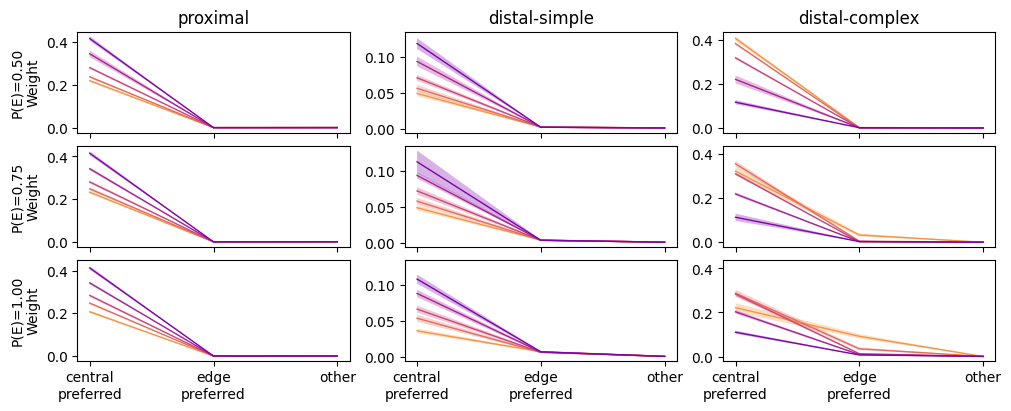

In [47]:
num_edges = len(metadata["edge_probabilities"])
num_ratios = len(metadata["dp_ratios"])
cmap = mpl.colormaps["plasma_r"]
colors = [cmap(ii) for ii in np.linspace(0, 1, num_ratios+4)[2:-2]]

fig, ax = plt.subplots(num_edges, 3, layout="constrained", figsize=(10, 4), sharex=True, sharey="col")
for iedge in range(num_edges):
    for igroup, sgname in enumerate(get_groupnames()):
        for iratio in range(num_ratios):
            data = np.stack([np.reshape(summary[wg][igroup, iratio, iedge], -1) for wg in weight_group_order])
            errorPlot(range(len(weight_group_order)), data, axis=1, ax=ax[iedge, igroup], color=colors[iratio], linewidth=1.0, alpha=0.3, handle_nans=True)
        # ax[iedge, igroup].set_ylim(0, 1)

for igroup, sgname in enumerate(get_groupnames()):
    ax[0, igroup].set_title(sgname)
    ax[-1, igroup].set_xticks(range(len(weight_group_order)), labels=labels)
for iedge in range(num_edges):
    ax[iedge, 0].set_ylabel(f"P(E)={metadata['edge_probabilities'][iedge]:.2f}\nWeight")

plt.show()

In [48]:
from src.debug import Timer


num_edges = len(metadata["edge_probabilities"])
num_ratios = len(metadata["dp_ratios"])
cmap = mpl.colormaps["plasma_r"]
colors = [cmap(ii) for ii in np.linspace(0, 1, num_ratios+4)[2:-2]]

example_ratio = 0
example_edge = 2
example_simulation = 0
example_neuron = 0

weight_group_colors = ["maroon", "red", "black"]

class ExampleViewer(Viewer):
     def __init__(self):
          self.add_integer("example_ratio", value=1, min=0, max=4)
          self.add_integer("example_edge", value=2, min=0, max=2)
          self.add_integer("example_simulation", min=0, max=9)
          self.add_integer("example_neuron", min=0, max=2)
          self.on_change(["example_ratio", "example_edge"], self.update_trajectory)

          self.c_traj = None

          self.update_trajectory(self.state)

     def update_trajectory(self, state):
          self.c_traj = {}
          for igroup, sgname in enumerate(get_groupnames()):
               self.c_traj[sgname] = {}
               for iwg, wg in enumerate(weight_group_order):
                    if igroup == 0 and wg == "edge-preferred":
                         continue
                    ctraj = trajectory[wg][igroup, state["example_ratio"], state["example_edge"]]
                    self.c_traj[sgname][wg] = ctraj
               
     def plot(self, state):
          fig, ax = plt.subplots(3, 2, layout="constrained", figsize=(7, 7))
          for igroup, sgname in enumerate(get_groupnames()):
               for iwg, wg in enumerate(weight_group_order):
                    if igroup == 0 and wg == "edge-preferred":
                         continue
                    c_traj = self.c_traj[sgname][wg]
                    all_sims = c_traj.reshape(-1, c_traj.shape[-1])
                    errorPlot(range(all_sims.shape[1]), all_sims, axis=0, ax=ax[igroup, 0], color=weight_group_colors[iwg], linewidth=1.0, alpha=0.3)
                    ax[igroup, 1].plot(c_traj[state["example_simulation"], state["example_neuron"]], color=weight_group_colors[iwg], linewidth=1.0)
               ax[igroup, 0].set_title(sgname)
               ax[igroup, 0].set_xlabel("Time")
               ax[igroup, 0].set_ylabel("Weight")
          return fig

viewer = ExampleViewer()
viewer.show()

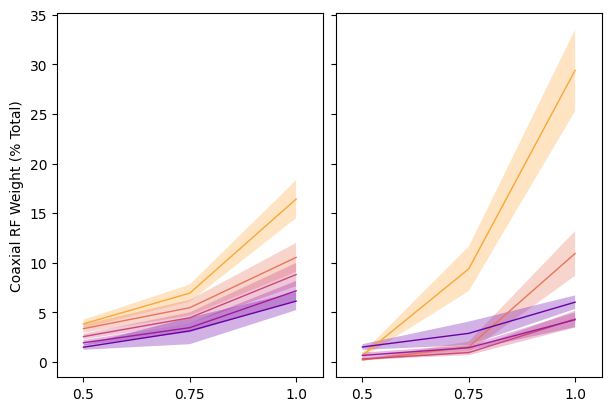

In [49]:
num_edges = len(metadata["edge_probabilities"])
num_ratios = len(metadata["dp_ratios"])
cmap = mpl.colormaps["plasma_r"]
cmap_pinch = 0.2
colors = [cmap(ii) for ii in np.linspace(cmap_pinch, 1-cmap_pinch, num_ratios)]

groups_to_plot = ["distal-simple", "distal-complex"]
idx_to_group = [1, 2]

max_ratio = 0
fig, ax = plt.subplots(1, 2, layout="constrained", figsize=(6, 4), sharex=True, sharey=True)
for iratio in range(num_ratios):
    for igroup, sgname in enumerate(groups_to_plot):
        idxgroup = idx_to_group[igroup]
        edge_preferred = np.reshape(summary["edge-preferred"][idxgroup, iratio], (num_edges, -1))
        total_weight = np.sum(np.stack([np.reshape(summary[wg][idxgroup, iratio], (num_edges, -1)) for wg in weight_group_order]), axis=0)
        ratio_edge_preferred = edge_preferred / total_weight
        errorPlot(range(num_edges), 100 * ratio_edge_preferred, axis=1, ax=ax[igroup], color=colors[iratio], linewidth=1.0, alpha=0.3)
        max_ratio = max(max_ratio, np.max(ratio_edge_preferred))

ax[0].set_xlim(-0.25, num_edges-0.75)
ax[0].set_ylabel("Coaxial RF Weight (% Total)")
ax[0].set_xticks(range(num_edges), labels=metadata["edge_probabilities"])
ax[1].set_xticks(range(num_edges), labels=metadata["edge_probabilities"])
plt.show()

In [39]:
def plot(state):
    dpratio = state["dpratio"]
    edge = state["edge"]
    simulation = state["simulation"]
    neuron = state["neuron"]

    valid_ratio = np.array(metadata["ratios"]) == dpratio
    valid_edge = np.array(metadata["edges"]) == edge
    idx_result = np.where(valid_ratio & valid_edge)[0][simulation]
    c_weights = results[idx_result]["weights"][neuron]
    norm_factors = get_norm_factor(results[idx_result]["sim"].neurons[neuron], norm_by_max_weight=True, norm_by_num_synapses=False, norm_by_total_synapses=True)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
    for i, sg in enumerate(get_groupnames()):
        ax[i].imshow(c_weights[sg].T / norm_factors[sg], cmap="gray_r", vmin=0, vmax=0.2, aspect="auto", interpolation="none")
    return fig

viewer = make_viewer(plot)
viewer.add_integer("dpratio", min=0, max=4)
viewer.add_integer("edge", min=0, max=2)
viewer.add_integer("simulation", min=0, max=9)
viewer.add_integer("neuron", min=0, max=2)
# viewer.show()

In [11]:
def plot(state):
    dpratio = state["dpratio"]
    edge = state["edge"]
    simulation = state["simulation"]
    neuron = state["neuron"]
    spacing = state["spacing"]
    vmax = state["vmax"]

    proximal_gabor = weights_to_gabor(weights["proximal"][dpratio, edge, simulation, neuron], SourcePopulationGabor.orientations, spacing=spacing)
    simple_gabor = weights_to_gabor(weights["distal-simple"][dpratio, edge, simulation, neuron], SourcePopulationGabor.orientations, spacing=spacing)
    complex_gabor = weights_to_gabor(weights["distal-complex"][dpratio, edge, simulation, neuron], SourcePopulationGabor.orientations, spacing=spacing)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
    ax[0].imshow(proximal_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[0].set_title(f"{np.max(proximal_gabor)}")
    ax[1].imshow(simple_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[1].set_title(f"{np.max(simple_gabor)}")
    ax[2].imshow(complex_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[2].set_title(f"{np.max(complex_gabor)}")
    return fig

viewer = make_viewer(plot)
viewer.add_integer("dpratio", min=0, max=4)
viewer.add_integer("edge", min=0, max=2)
viewer.add_integer("simulation", min=0, max=9)
viewer.add_integer("neuron", min=0, max=2)
viewer.add_integer("spacing", value=2, min=0, max=10)
viewer.add_float("vmax", value=0.5, min=0.0, max=1.0)
# viewer.show()

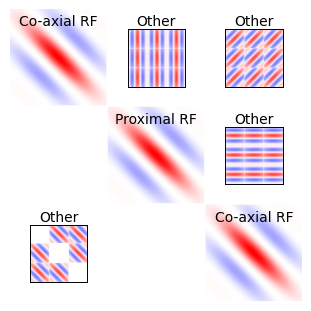

In [27]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from src.iaf.plotting import build_tuning_type_axes

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="constrained")
build_tuning_type_axes(ax, fontsize=10, alternate_pinch=0.2, other_label_pad=0.915)
plt.show()